# Did government type have an effect on restrictive COVID-19 measures?


## Data Analysis

In [2]:
import requests
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import psycopg2
import re
import datetime as dt
from bs4 import BeautifulSoup

sns.set()
sns.set_style("darkgrid")

### Obtain Democracy Index

In [3]:
# Scraping democracy index from Wikipedia page
response = requests.get("https://en.wikipedia.org/wiki/Democracy_Index")
soup = BeautifulSoup(response.text)

countries, scores, regimetypes, regions = [], [], [], []

region = ''
for line in soup.find_all("table")[5].find_all("tr")[1:]:
    tableline = [a.text for a in line.find_all("td")]

    # the first country per region, as listed on the wikipedia table
    if line.find("td").has_attr("rowspan"):
        region = tableline[0].strip()
        tableline = tableline[1:]
    
    countries.append(tableline[1].strip())
    scores.append(tableline[-1].strip())
    regimetypes.append(tableline[2].strip())
    regions.append(region)


In [4]:
# Convert democracy index lists into dataframe
dem_index = pd.DataFrame([countries, scores, regimetypes, regions]).T
dem_index.columns=["country", "dem_score", "regimetype", "region"]
dem_index.dem_score = dem_index.dem_score.apply(float)

In [5]:
dem_index

,country,dem_score,regimetype,region
0,Canada,9.24,Full democracy,North America
1,United States,7.92,Flawed democracy,North America
2,Austria,8.16,Full democracy,Western Europe
3,Belgium,7.51,Flawed democracy,Western Europe
4,Cyprus,7.56,Flawed democracy,Western Europe
...,...,...,...,...
162,Tanzania,5.10,Hybrid regime,Sub-Saharan Africa
163,Togo,2.80,Authoritarian,Sub-Saharan Africa
164,Uganda,4.94,Hybrid regime,Sub-Saharan Africa
165,Zambia,4.86,Hybrid regime,Sub-Saharan Africa


### Load Government Response and Epidemiology from OxCOVID19

In [6]:
conn = psycopg2.connect(
    host='covid19db.org',
    port=5432,
    dbname='covid19',
    user='covid19',
    password='covid19')
cur = conn.cursor()

In [7]:
# Load government tracking data from OX COVID
sql_command_all = """SELECT * FROM government_response\
    WHERE date < '2020-04-01'\
    ORDER by date ASC"""
df_govtrack_all = pd.read_sql(sql_command_all, conn)

# to datetime
df_govtrack_all.date = pd.to_datetime(df_govtrack_all['date'])
df_govtrack_all.government_response_index = df_govtrack_all.government_response_index.apply(float)

In [8]:
# Load epidemiology data from OX COVID
sql_command_epi = """SELECT * FROM epidemiology\
    WHERE date < '2020-04-01'\
    ORDER by date ASC"""
df_epidemiology = pd.read_sql(sql_command_epi, conn)

# to datetime
df_epidemiology.date = pd.to_datetime(df_epidemiology['date'])

### Determine "first case of COVID-19" for each country

In [9]:
# Determine "first case of covid" for each country
first_confirmed = df_epidemiology[df_epidemiology.confirmed>0]\
    .sort_values(by="date")[["country", "date", "confirmed", "gid"]]\
    .groupby("country")\
    .first()

# Extract GIDs from arrays for each row
first_confirmed.gid = first_confirmed.gid.dropna().apply(lambda x: x[0])

# Drop rows with null GIDs. These are continents (ex: Africa, America, etc)
first_confirmed = first_confirmed[~first_confirmed.gid.isna()]

# Some GIDs are have extra numbers after them, get rid of them (ex: POL.3.6_1)
first_confirmed.gid = first_confirmed.gid.apply(
    lambda x: re.search("(\w\w\w)",x).group(1))

### Filter for first record of government's restrictions on internal movement

In [10]:
# Selecting only "Restrictions on internal movement" government flag
gov_flags = ['c7_restrictions_on_internal_movement']
gov_flags.extend(["date", "country", "gid"])

# Dataframe with all of the government flags from above, melted
df_melt_all = df_govtrack_all[gov_flags]\
    .sort_values(by="date")\
    .melt(id_vars=["date", "country", "gid"])\
    .dropna()

# Merge in first confirmed date for each country
df_melt_all = df_melt_all.merge(first_confirmed, how="left", on=["gid"])\
    .rename(columns={"date_x": "date", "date_y": "first_confirmed_date"})\
    .drop(columns="confirmed")

# Calculate the number of days for each 
df_melt_all["response_since_first_infection"] = \
    df_melt_all["date"] - df_melt_all["first_confirmed_date"]

In [11]:
# The countries that do not seem to exist in the OxCovid database
df_melt_all[df_melt_all.first_confirmed_date.isna()].country.unique()

array(['Solomon Islands', 'Macao', 'Falkland Islands', 'Tajikistan',
       'Kiribati', 'Vanuatu', 'Pitcairn Islands', 'Hong Kong', 'Malawi',
       'Tonga', 'Turkmenistan', 'Lesotho', 'Yemen', 'South Sudan'],
      dtype=object)

### Merge in data about first confirmed COVID-19 case and Democracy Index

In [12]:
# Only looking at values above a 1 in score (i.e. most stringent scores)
# 1=Recommended, 2=Restricted
df_all_countries= df_melt_all[df_melt_all.value>1]\
    .groupby(['variable', 'country'])\
    .first()\
    .unstack()["response_since_first_infection"]\
    .melt()\
    .rename(columns={"value": "response_since_first_infection"})

# Extract just the number of "days" from the time detla
df_all_countries["response_since_first_infection"] = \
    df_all_countries["response_since_first_infection"].apply(lambda a: a.days)

# Drop the countries with no data about confirmed cases
df_all_countries = \
    df_all_countries[~df_all_countries["response_since_first_infection"].isna()]

# Merge back in the date of the first case of covid
df_all_countries = df_all_countries\
    .merge(first_confirmed.reset_index()[["country", "gid", "date"]], 
           on="country")\
    .rename(columns={"date": "first_case"})

In [13]:
# Merge in democracy score
df_merge = df_all_countries.merge(dem_index, on="country")


### Convert "first case" date to different time frames for extra analysis

In [14]:
# week of year
df_merge['first_case_woy'] = df_merge.first_case.dt.isocalendar().week 

# every [two weeks] of year
df_merge['first_case_biweekly'] = df_merge.first_case_woy//2

# month of year
df_merge['first_case_month'] = df_merge.first_case.dt.month    

# date as ordinal
df_merge['first_case_ordinal'] = pd.to_datetime(df_merge['first_case'])\
    .apply(lambda date: date.toordinal())                               


# A ranking/ordering for regime type in order of authoritarian to democratic
regimetype_order = {"Authoritarian": 0, "Hybrid regime": 1, 
                    "Flawed democracy": 2, "Full democracy": 3}
df_merge["regimetype_order"] = df_merge.regimetype.map(regimetype_order)

### Calculate average response time before and after Feb 15 for each regime type


In [15]:
average_response_time_before_feb_15 = \
    df_merge[df_merge.first_case < dt.datetime(2020,2,15)]\
    .groupby(["regimetype_order", "regimetype"])\
    .mean()["response_since_first_infection"]\
    .to_frame()\
    .rename(columns={"response_since_first_infection": "avg_response_days"})\
    .apply(lambda x: round(x, 2))\
    .reset_index()\
    .drop(columns=["regimetype_order"])

average_response_time_after_feb_15 = \
    df_merge[df_merge.first_case >= dt.datetime(2020,2,15)]\
    .groupby(["regimetype_order", "regimetype"])\
    .mean()["response_since_first_infection"]\
    .to_frame()\
    .rename(columns={"response_since_first_infection": "avg_response_days"})\
    .apply(lambda x: round(x, 2))\
    .reset_index()\
    .drop(columns=["regimetype_order"])

### Top 3 Countries Per Regime Type with Fastest and Slowest Responses

In [16]:
fastest_by_regimetype = df_merge\
    .sort_values(by="response_since_first_infection")\
    .groupby("regimetype")\
    .head(3)
fastest_by_regimetype['speed'] = 'fast'

slowest_by_regimetype = df_merge\
    .sort_values(by="response_since_first_infection")\
    .groupby("regimetype")\
    .tail(3)\
    .sort_values(by="regimetype")
slowest_by_regimetype['speed'] = 'slow'

top_response_by_regimetype = fastest_by_regimetype\
    .append(slowest_by_regimetype)\
    .sort_values(by=["speed", "regimetype_order", "first_case"])\
    [["country", "response_since_first_infection", "first_case", "regimetype"]]
top_response_by_regimetype.reset_index(inplace=True, drop=True)

### Calculate Other Helper Variables

In [17]:
# order of regimes from most to least authoritarian; used for plotting purposes
regime_order = ["Authoritarian", "Hybrid regime", 
                "Flawed democracy", "Full democracy"]

### Render Graphs

In [49]:
def render_response_time_regimetype(df, order, plt, fignum, figsize=(10,5)):
    fig, ax = plt.subplots(figsize=figsize)

    g = sns.boxplot(ax=ax, x="regimetype", y="response_since_first_infection", 
                    order=order,
                    data=df, palette="Set1")
    plt.xlabel('Regime Type')
    plt.ylabel('Response Time (Days) Since First Covid Case')
    plt.title(f'Fig {fignum}: Response Time for Internal Restriction Measures, by Regime Type', 
              fontsize=20);

In [52]:
def render_response_time_regimetype_firstcovid(df, plt, fignum, figsize=(18,8)):
    df_merge_months = df.copy()

    # Special case: China's first case was december 31, 2019. 
    # We will interpret this as january
    df_merge_months.loc[df_merge_months.country=="China", 
                        "first_case_month"] = 1

    fig, ax = plt.subplots(1,2, figsize=figsize)

    g0 = sns.boxplot(x="first_case_month", y="response_since_first_infection",  
                     hue_order=regime_order, hue="regimetype", ax=ax[0],
                     data=df_merge_months, palette="Set1")

    g1 = sns.stripplot(x="first_case_woy", y="response_since_first_infection", 
                       zorder=1, size=14, linewidth=1, hue="regimetype", 
                       ax=ax[1], dodge=True,hue_order=regime_order, 
                       data=df_merge_months, palette="Set1")

    g0.set_title('Response Time (By Month)')
    g1.set_title('Response Time (By Week)')

    g0.set_xlabel('First Case of Covid (Month of Year)')
    g1.set_xlabel('First Case of Covid (Week of Year)')

    g0.set_ylabel('Response Time Since First Case (Days)')
    g1.set_ylabel('Response Time Since First Case (Days)')

    fig.suptitle(f'Fig {fignum}: Response Time, by Regime Type and First Covid Case', 
                 position=(.5,1), fontsize=25);

In [59]:
def render_avg_response_by_regimetype(df_before, df_after, plt, fignum, figsize=(15,5)):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=figsize)
    plot_barplot_subplot(df_before, axes[0], "Before Feb 15")
    plot_barplot_subplot(df_after, axes[1], "After Feb 15")

    fig.suptitle(f"Fig {fignum}: Average Response Times for Internal Movement Restrictions, by Regime Type", 
                 y=0.98, fontsize=25)
    fig.tight_layout()
    
def plot_barplot_subplot(df, ax, title_suffix):
    g = sns.barplot(x="regimetype", y="avg_response_days", data=df, 
                    ax=ax, palette="Set1")

    for index, row in df.iterrows():
        g.text(row.name, row.avg_response_days+1, row.avg_response_days, 
               color='black', fontsize=15, ha="center")
    
    ax.set_ylim(0,80)
    ax.set_ylabel("Average Response Time (Days)")
    ax.set_xlabel("Regime Type")
    ax.title.set_text(f"Countries with First Case {title_suffix}")

In [63]:
def render_response_time_kde(df, plt, fignum, figsize=(15,5)):
    plt.rcParams["figure.figsize"] = figsize

    data = df[["country", "response_since_first_infection", "first_case", 
                     "dem_score", "regimetype", "region"]]\
        .groupby("regimetype")\
        .apply(lambda x: x.sort_values("response_since_first_infection"))\
        .drop(columns=["regimetype"])\
        .reset_index(0).reset_index(drop=True)

    sns.kdeplot(data=data, x="response_since_first_infection", hue="regimetype", 
                hue_order=regime_order, palette="Set1", fill=True, bw_adjust=.6, 
                linewidth=3, alpha=0.1)

    plt.xlabel('Response Time Since First Infection (Days)')
    plt.title(f'Fig {fignum}: Distribution of Response Time, By Regime Type', 
              fontsize=23);

In [65]:
def render_response_time_dumbbell(df, plt, fignum, figsize=(8,12)):
    # plotting inspired by https://nikkimarinsek.com/blog/how-to-make-an-arrow-plot
    data = df.copy()
    ax = plt.figure(figsize=figsize)
    ax = sns.stripplot(data=data, x='first_case', y='country', orient='h', 
                       size=12, hue_order=regime_order, hue='regimetype', 
                       palette='Set1')
    
    #add start points
    arrow_starts = data['first_case'].values
    arrow_lengths = data['response_since_first_infection']

    # Add number of days to the label on the y-axis
    new_labels = [f"{c.get_text()} ({val} days)" for (c, val) in \
         zip(ax.get_yticklabels(), 
             data.response_since_first_infection.values.astype(int).astype(str))]
    ax.set_yticklabels(new_labels)

    #add arrows to plot
    for i, subject in enumerate(data['country']):
        if arrow_lengths[i] != 0:
            ax.arrow(arrow_starts[i],        #x start point
                     i,                      #y start point
                     arrow_lengths[i],       #change in x 
                     0,                      #change in y
                     head_width=.3,         #arrow head width
                     head_length=1,        #arrow head length
                     width=0.01,              #arrow stem width
                     fc='gray',             #arrow fill color
                     ec='gray')             #arrow edge color
    plt.axhline(y=11.5, color='gray', linestyle='--')
    plt.xticks(rotation=45)
    plt.legend(loc="upper left", borderaxespad=0.)
    plt.xlabel('Date')
    
    
    plt.text(1.03, 0.8, 'Top 3 Countries with Fastest Responses',
        horizontalalignment='left',
        verticalalignment='bottom',
        transform=ax.transAxes)
    plt.text(1.03, 0.3, 'Top 3 Countries with Slowest Responses',
        horizontalalignment='left',
        verticalalignment='bottom',
        transform=ax.transAxes)
    
    
    plt.title(f'Fig {fignum}: Countries with Fastest and Slowest Responses, by Regime Type', 
              fontsize=20);

## Results

The results of the analysis as follows show that at first glance, authoritarian countries seem to have responded faster than democratic countries in enacting strict rules about internal movements. Some authoritarian countries (such as Libya and Venezuela) enacted restrictions days before reporting their first COVID-19 case. 

`Fig 1` groups speed of response to enact internal restriction measures by regime type. The more authoritarian the regime type of the government, the quicker the stringent response on internal movement restrictions. This seems to confirm the hypothesis that authoritarian governments act quicker to enact internal restrictive measures, whereas democratic governments are slower to do so. 

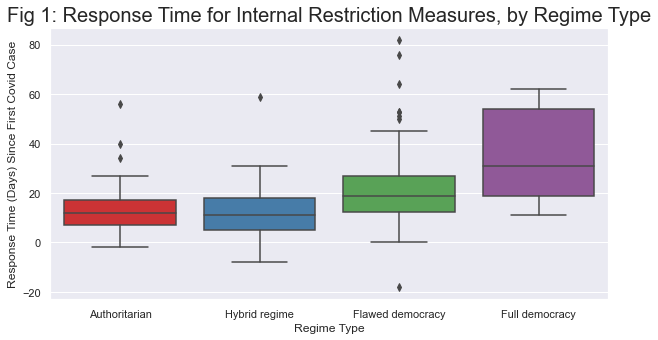

In [72]:
render_response_time_regimetype(df_merge, regime_order, plt, 1)
plt.savefig('covidblog_img/plot1.png', bbox_inches = "tight")

However, upon separating the speed of response by the date of the first COVID-19 case, the analysis shows that the date of first infection has a large influence on quickness of response. `Fig 2` shows the government response time, separated by regime type, with the date of the first COVID-19 case aggregated by month and by week. For later dates of first COVID-19 cases, the authoritarian nature of the regime seems to have less impact on response time. 

In the response times aggregated by month, the mean of the authoritarian regimes' response times is noticeably quicker in the first two months, compared to other regime types. By the third month, the means seem to equalize across all regime types. In the response times aggregated by week, the downward trend becomes apparent as time goes on. For the countries with earlier first COVID-19 cases (before Week 8), authoritarian regimes tended to respond quicker than other regime types as indicated by the red data points. For the countries with later first COVID-19 dates (i.e. after Week 8), the regime type tended to have less of an influence in response time, as the data points are closely clustered and less variable. 

Overall, the date of the first case of COVID-19 is influential upon the number of days it took for a government to enact restrictions, although the regime type of that government is not negligible. One way to interpret this can be that, for countries with earlier first cases of COVID-19, authoritarian regimes were more likely to enact stringent internal movement measures. For countries with later first cases of COVID-19, the regime type had less of an influence on stringency measures.

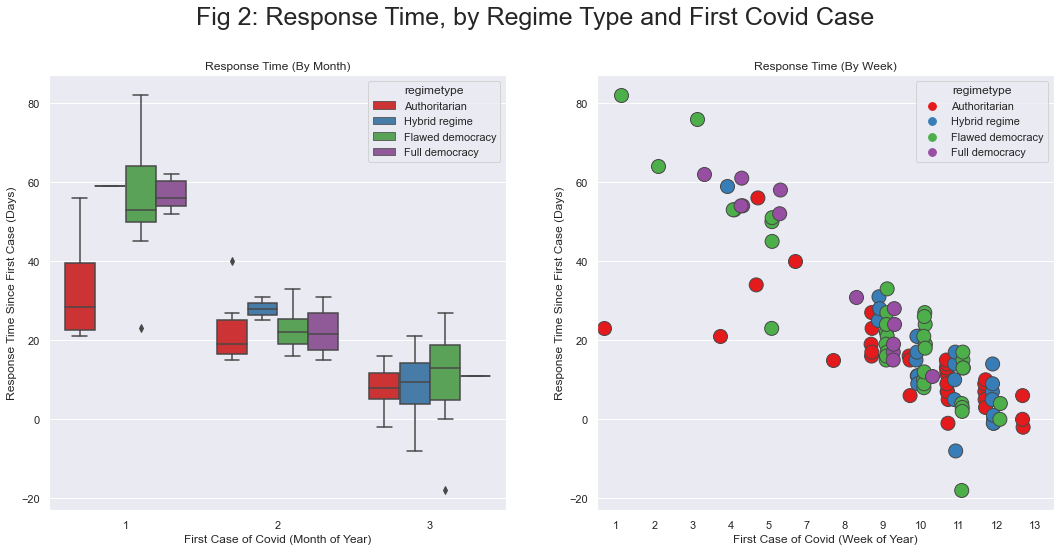

In [73]:
render_response_time_regimetype_firstcovid(df_merge, plt, 2)
plt.savefig('covidblog_img/plot2.png', bbox_inches = "tight")

`Fig 3` shows a government's response to impose internal movement restrictions for countries that experienced their first case of COVID-19 before and after February 15, 2020. February 15 was chosen as the cutoff date because, as seen in `Fig 2`, around Week 8 was when clustering behavior began to emerge. The eighth week of 2020 began with the date January 16.

For countries with first case before February 15, authoritarian countries responded on average around 20 days quicker. For countries with first case after February 15, all countries tended to respond quicker, with authoritarian regimes having less of an influence on response time. For countries with first case after February 15, democracies tended to take the longest to respond, while this trend is not as apparent for countries with first cases before February 15.

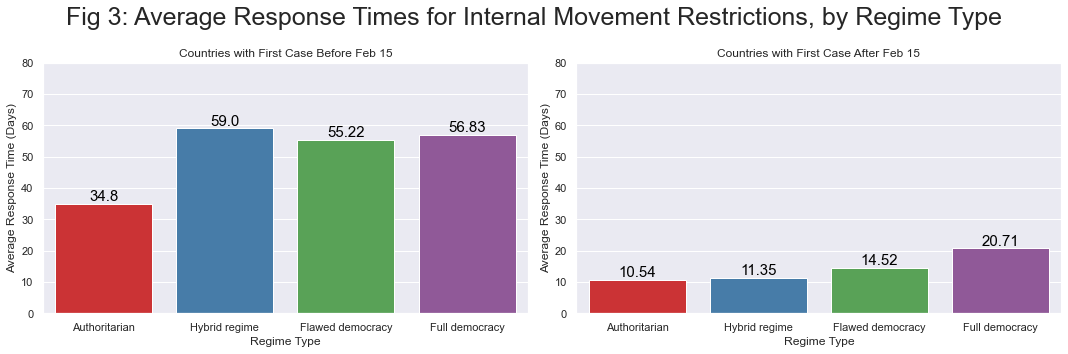

In [74]:
render_avg_response_by_regimetype(average_response_time_before_feb_15, 
                                  average_response_time_after_feb_15, 
                                  plt, 3)              
plt.savefig('covidblog_img/plot3.png', bbox_inches = "tight")

`Fig 4` shows the distribution of responses for each regime type. Authoritarian, hybrid, and flawed democracy regimes tend to be unimodal with long right tails, meaning that there was some unity in terms of their responses, but with some variety outside of the mode. The distribution of democratic regimes' response time, as indicated by the purple line, are less certain. The distribution of democratic regimes' response time is bimodal and variable, suggesting that the responses for different democratic regimes varied greatly.

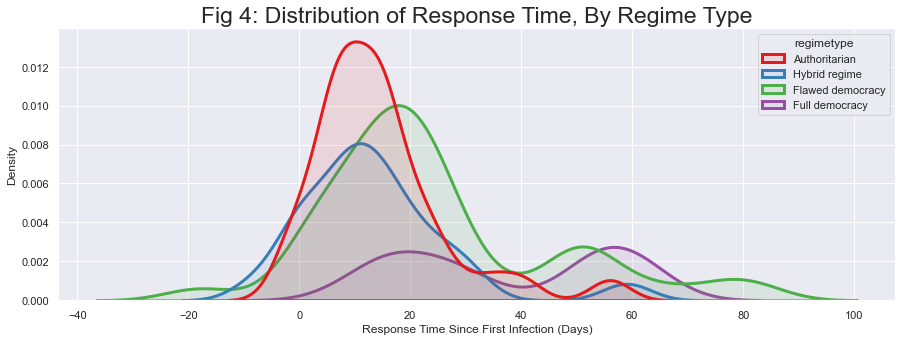

In [75]:
render_response_time_kde(df_merge, plt, 4)
plt.savefig('covidblog_img/plot4.png', bbox_inches = "tight")

`Fig 5` plots the top 3 countries with slowest and top 3 countries with fastest response, for each regime type. The dot indicates the date of the first COVID-19 case, and the end of the arrow indicates the date of the first response to enact internal movement restrictions. An arrow going to the left indicates the country having responded before their first case. Above the dotted line are the top 3 countries per regime type that responded the quickest. Below the dotted line are the top 3 countries per regime type that responded the slowest.

This graph confirms the observations made above, that countries with later first cases of COVID-19 responded quicker than countries with earlier first cases of COVID-19. However, even within this framework, we can note that the response of the quickest democratic countries is vastly different from the response of the quickest countries in the other 3 regime types. Even the fastest democratic countries did not respond proactively (i.e. before a confirmed case of COVID-19), whereas other regime types did.

As for countries with the slowest responses, there seems to be little variability among regime types. Countries with earlier first cases of COVID-19, regardless of regime type, tended to take a longer time to respond than countries with later first cases of COVID-19.

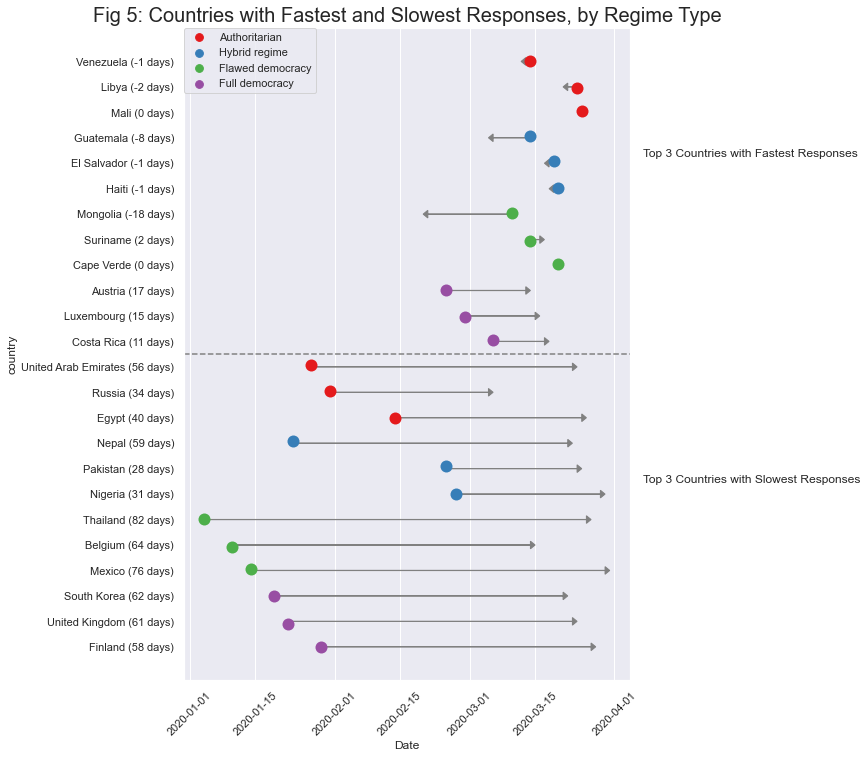

In [76]:
render_response_time_dumbbell(top_response_by_regimetype, plt, 5)
plt.savefig('covidblog_img/plot5.png', bbox_inches = "tight")